This notebook explores how to extract features from oriented 3D brains and tumor masks.
We are using [this radiomic feature library](https://pyradiomics.readthedocs.io/en/latest/index.html).

In [1]:
import glob
import os
import random
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
import math
from tqdm.auto import tqdm
import SimpleITK as sitk
import radiomics

In [2]:
df = pd.read_csv('../input/train_labels_folds-v1.csv')
df.head()

,BraTS21ID,MGMT_value,fold
0,0,1,2
1,2,1,2
2,3,0,1
3,5,1,2
4,6,1,0


In [3]:
REG_DIR = '../input/registered_cases_v3_320x320x160/train/'
SEG_DIR = '../output/OOF_segmentations/'

In [4]:
bratsid = f'{int(df.BraTS21ID.values[0]):05d}'
reg_fn = os.path.join(REG_DIR, f'{bratsid}.npy')
seg_fn = os.path.join(SEG_DIR, f'{bratsid}_seg.npy')
reg_arr = np.load(reg_fn)
seg_arr = np.load(seg_fn)

reg_arr = reg_arr.swapaxes(0,3)
reg_arr.shape, seg_arr.shape

((3, 320, 320, 160), (1, 320, 320, 160))

In [5]:
reg = sitk.GetImageFromArray(reg_arr[0])
seg = sitk.GetImageFromArray(np.array(seg_arr > 0.5).astype(np.uint8)[0])

In [6]:
%%time

def _get_shape_features(reg, seg, feats):
    """ Tumor shape descriptors """
    shape = radiomics.shape.RadiomicsShape(reg, seg)
    feats['mesh_volume'] = shape.getMeshVolumeFeatureValue()
    feats['surface_area'] = shape.getSurfaceAreaFeatureValue()
    feats['surface_volume_ratio'] = shape.getSurfaceVolumeRatioFeatureValue()
    feats['sphericity'] = shape.getSphericityFeatureValue()
    feats['spherical_disproportion'] = shape.getSphericalDisproportionFeatureValue()
    feats['maximum_3d_diameter'] = shape.getMaximum3DDiameterFeatureValue()
    feats['maximum_2d_diameter_slice'] = shape.getMaximum2DDiameterSliceFeatureValue()
    feats['maximum_2d_diameter_column'] = shape.getMaximum2DDiameterColumnFeatureValue()
    feats['maximum_2d_diameter_row'] = shape.getMaximum2DDiameterRowFeatureValue()
    feats['major_axis_length'] = shape.getMajorAxisLengthFeatureValue()
    feats['minor_axis_length'] = shape.getMinorAxisLengthFeatureValue()
    feats['least_axis_length'] = shape.getLeastAxisLengthFeatureValue()
    feats['elongation'] = shape.getElongationFeatureValue()
    feats['flatness'] = shape.getFlatnessFeatureValue()
    
def _get_firstorder_features(reg, seg, channel, feats):
    """ Tumor voxel intensity statistics """
    firstorder = radiomics.firstorder.RadiomicsFirstOrder(reg,seg)
    firstorder._initCalculation()
    feats[f'energy_{channel}'] = firstorder.getEnergyFeatureValue()[0]
    feats[f'total_energy_{channel}'] = firstorder.getTotalEnergyFeatureValue()[0]
    feats[f'entropy_{channel}'] = firstorder.getEntropyFeatureValue()[0]
    feats[f'minimum_{channel}'] = firstorder.getMinimumFeatureValue()[0]
    feats[f'10percentile_{channel}'] = firstorder.get10PercentileFeatureValue()[0]
    feats[f'90percentile_{channel}'] = firstorder.get90PercentileFeatureValue()[0]
    feats[f'maximum_{channel}'] = firstorder.getMaximumFeatureValue()[0]
    feats[f'mean_{channel}'] = firstorder.getMeanFeatureValue()[0]
    feats[f'median_{channel}'] = firstorder.getMedianFeatureValue()[0]
    feats[f'mean_abs_dev_{channel}'] = firstorder.getMeanAbsoluteDeviationFeatureValue()[0]
    feats[f'robust_mean_abs_dev_{channel}'] = firstorder.getRobustMeanAbsoluteDeviationFeatureValue()[0]
    feats[f'skewness_{channel}'] = firstorder.getSkewnessFeatureValue()[0]
    feats[f'kurtosis_{channel}'] = firstorder.getKurtosisFeatureValue()[0]
    feats[f'uniformity_{channel}'] = firstorder.getUniformityFeatureValue()[0]
    
def _get_glcm_features(reg, seg, channel, feats):
    """ Gray level co-occurence matrix features """
    glcm = radiomics.glcm.RadiomicsGLCM(reg,seg)
    glcm._initCalculation()
    feats[f'autocorrelation_{channel}'] = glcm.getAutocorrelationFeatureValue()[0]
    feats[f'joint_avg_{channel}'] = glcm.getJointAverageFeatureValue()[0]
    feats[f'contrast_{channel}'] = glcm.getContrastFeatureValue()[0]
    feats[f'cluster_prominence_{channel}'] = glcm.getClusterProminenceFeatureValue()[0]
    feats[f'cluster_shade_{channel}'] = glcm.getClusterShadeFeatureValue()[0]
    feats[f'cluster_tendency_{channel}'] = glcm.getClusterTendencyFeatureValue()[0]
    feats[f'correlation_{channel}'] = glcm.getCorrelationFeatureValue()[0]
    feats[f'difference_average_{channel}'] = glcm.getDifferenceAverageFeatureValue()[0]
    feats[f'difference_entropy_{channel}'] = glcm.getDifferenceEntropyFeatureValue()[0]
    feats[f'difference_variance_{channel}'] = glcm.getDifferenceVarianceFeatureValue()[0]
    feats[f'joint_energy_{channel}'] = glcm.getJointEnergyFeatureValue()[0]
    feats[f'joint_entropy_{channel}'] = glcm.getJointEntropyFeatureValue()[0]
    
def _get_position_features(seg_arr, feats):
    """ Tumor position stats """
    nonzero_coords = np.argwhere(seg_arr > 0)
    for axis in range(3):
        axis_coords = nonzero_coords[:,axis]
        feats[f'minimum_ax_{axis}'] = np.min(axis_coords)
        feats[f'percentile10_ax_{axis}'] = np.percentile(axis_coords, 10)
        feats[f'mean_ax_{axis}'] = np.mean(axis_coords)
        feats[f'median_ax_{axis}'] = np.median(axis_coords)
        feats[f'percentile90_ax_{axis}'] = np.percentile(axis_coords, 90)
        feats[f'maximum_ax_{axis}'] = np.max(axis_coords)

def get_radiomics_features(reg_fn, seg_fn):
    """ Returns a dictionary of features """
    feats = {'BraTS21ID' : os.path.basename(reg_fn).split('.')[0]}
    
    reg_arr = np.load(reg_fn)
    seg_arr = np.load(seg_fn)
    reg_arr = reg_arr.swapaxes(0,3)
    seg_arr = np.array(seg_arr > 0.5).astype(np.uint8)[0]
    seg = sitk.GetImageFromArray(seg_arr)
    regs = [sitk.GetImageFromArray((reg_arr[channel] * 255).astype(np.uint8)) for channel in range(3)]
    
    # Shape features
    _get_shape_features(regs[0], seg, feats)
    
    # Firstorder statistics features for all channels
    for channel in range(3):
        _get_firstorder_features(regs[channel], seg, channel, feats)
        
    # GLCM features
    for channel in range(3):
        _get_glcm_features(regs[channel], seg, channel, feats)
        
    # Position features
    _get_position_features(seg_arr, feats)
    
    return feats
    
get_radiomics_features(reg_fn, seg_fn)

CPU times: user 5.36 s, sys: 585 ms, total: 5.95 s
Wall time: 5.86 s


{'BraTS21ID': '00000',
 'mesh_volume': 301110.6666666667,
 'surface_area': 33384.58764818915,
 'surface_volume_ratio': 0.11087148794083175,
 'sphericity': 0.6507620247167492,
 'spherical_disproportion': 1.536660041641582,
 'maximum_3d_diameter': 262.484285243898,
 'maximum_2d_diameter_slice': 111.11255554616679,
 'maximum_2d_diameter_column': 251.19912420229494,
 'maximum_2d_diameter_row': 260.7393334347543,
 'major_axis_length': 129.97844469937655,
 'minor_axis_length': 90.26491943747747,
 'least_axis_length': 41.490678170455446,
 'elongation': 0.694460682663565,
 'flatness': 0.31921199139148076,
 'energy_0': 1554973980.0,
 'total_energy_0': 1554973980.0,
 'entropy_0': 2.0326618383851285,
 'minimum_0': 19.0,
 '10percentile_0': 37.0,
 '90percentile_0': 104.0,
 'maximum_0': 182.0,
 'mean_0': 66.85159231019357,
 'median_0': 60.0,
 'mean_abs_dev_0': 22.628455980370003,
 'robust_mean_abs_dev_0': 17.802429314241262,
 'skewness_0': 0.5299444812522931,
 'kurtosis_0': 2.3333351685602013,
 'uni

### Collect and save features

In [7]:
feature_dicts = []

for _id in tqdm(df.BraTS21ID.values):
    bratsid = f'{int(_id):05d}'
    reg_fn = os.path.join(REG_DIR, f'{bratsid}.npy')
    seg_fn = os.path.join(SEG_DIR, f'{bratsid}_seg.npy')
    if os.path.exists(reg_fn) and os.path.exists(seg_fn):
        feature_dicts.append(get_radiomics_features(reg_fn, seg_fn))

  0%|          | 0/585 [00:00<?, ?it/s]

In [9]:
df_feature = pd.DataFrame(feature_dicts)
df_feature['BraTS21ID'] = [int(val) for val in df_feature['BraTS21ID'].values]
df_all = pd.merge(df, df_feature, on='BraTS21ID')
df_all.head()

,BraTS21ID,MGMT_value,fold,mesh_volume,surface_area,surface_volume_ratio,sphericity,spherical_disproportion,maximum_3d_diameter,maximum_2d_diameter_slice,...,mean_ax_1,median_ax_1,percentile90_ax_1,maximum_ax_1,minimum_ax_2,percentile10_ax_2,mean_ax_2,median_ax_2,percentile90_ax_2,maximum_ax_2
0,0,1,2,301110.666667,33384.587648,0.110871,0.650762,1.536660,262.484285,111.112556,...,206.839405,206.0,239.0,274,44,54.0,68.840251,69.0,82.0,95
1,2,1,2,739689.875000,57068.539173,0.077152,0.693086,1.442822,185.002703,130.311166,...,223.715294,225.0,263.0,285,47,61.0,84.275808,83.0,109.0,125
2,3,0,1,467699.583333,38412.140673,0.082130,0.758566,1.318276,142.112631,112.361025,...,188.199792,187.0,224.0,247,89,105.0,123.949091,124.0,143.0,155
3,5,1,2,828724.500000,64755.495510,0.078139,0.658892,1.517699,193.344253,139.717572,...,221.259213,220.0,265.0,295,76,90.0,109.686949,109.0,131.0,151
4,6,1,0,819950.625000,56526.628000,0.068939,0.749473,1.334270,191.167466,176.229963,...,170.564636,167.0,228.0,269,51,66.0,88.423948,88.0,112.0,133


In [10]:
df_all.to_csv('../input/train_feature_data_v1.csv')

## Checkpoint

In [11]:
df_all = pd.read_csv('../input/train_feature_data_v1.csv')
df_all.head()

,Unnamed: 0,BraTS21ID,MGMT_value,fold,mesh_volume,surface_area,surface_volume_ratio,sphericity,spherical_disproportion,maximum_3d_diameter,...,mean_ax_1,median_ax_1,percentile90_ax_1,maximum_ax_1,minimum_ax_2,percentile10_ax_2,mean_ax_2,median_ax_2,percentile90_ax_2,maximum_ax_2
0,0,0,1,2,301110.666667,33384.587648,0.110871,0.650762,1.536660,262.484285,...,206.839405,206.0,239.0,274,44,54.0,68.840251,69.0,82.0,95
1,1,2,1,2,739689.875000,57068.539173,0.077152,0.693086,1.442822,185.002703,...,223.715294,225.0,263.0,285,47,61.0,84.275808,83.0,109.0,125
2,2,3,0,1,467699.583333,38412.140673,0.082130,0.758566,1.318276,142.112631,...,188.199792,187.0,224.0,247,89,105.0,123.949091,124.0,143.0,155
3,3,5,1,2,828724.500000,64755.495510,0.078139,0.658892,1.517699,193.344253,...,221.259213,220.0,265.0,295,76,90.0,109.686949,109.0,131.0,151
4,4,6,1,0,819950.625000,56526.628000,0.068939,0.749473,1.334270,191.167466,...,170.564636,167.0,228.0,269,51,66.0,88.423948,88.0,112.0,133


## Feature model

In [12]:
import xgboost as xgb
from sklearn import linear_model
import optuna
import seaborn as sns

In [13]:
all_feat_names = df_all.columns.to_list()[4:]
corr = df_all[['MGMT_value'] + all_feat_names].corr()

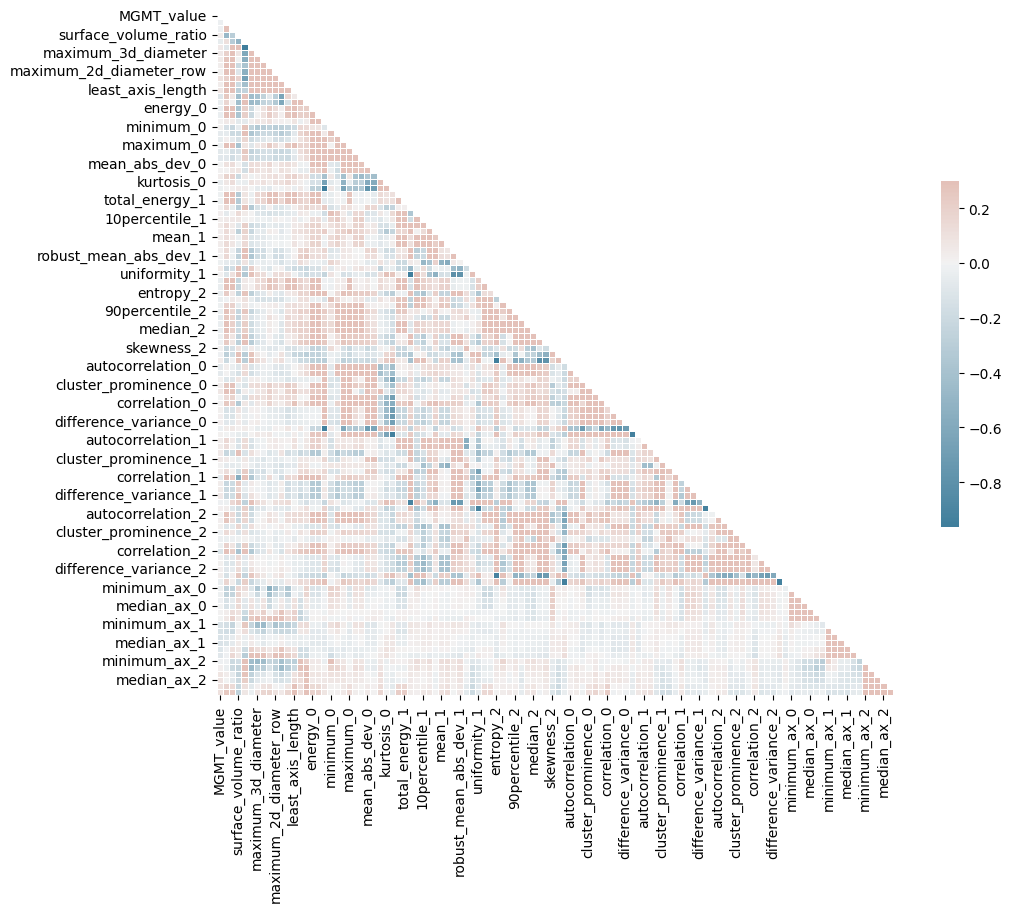

In [14]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.close('all')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [15]:
mgmt_corr_sorted = corr['MGMT_value'].sort_values()
mgmt_corr_sorted[:3], mgmt_corr_sorted[-4:-1]

(percentile10_ax_1   -0.141412
 minimum_ax_1        -0.128988
 median_ax_1         -0.126161
 Name: MGMT_value, dtype: float64,
 percentile90_ax_2    0.088859
 major_axis_length    0.096726
 maximum_ax_2         0.099119
 Name: MGMT_value, dtype: float64)

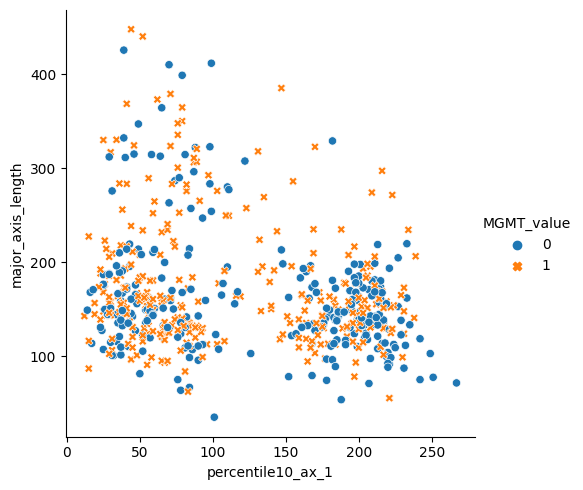

In [16]:
sns.relplot(x='percentile10_ax_1', y="major_axis_length", hue="MGMT_value", style="MGMT_value", data=df_all)
plt.show()

In [106]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

def get_data(fold, features):
    df = df_all.dropna(inplace=False)
    scaler = StandardScaler()
    
    df_train = df[df.fold != fold]
    df_val = df[df.fold == fold]
    if len(df_val) == 0:
        df_val = df[df.fold == 0]
    
    # shuffle train
    df_train = df_train.sample(frac=1)
    
    y_train = df_train.MGMT_value.to_numpy().reshape((-1,1)).astype(np.float32)
    y_val = df_val.MGMT_value.to_numpy().reshape((-1,1)).astype(np.float32)
    
    X_train = df_train[features].to_numpy().astype(np.float32)
    X_val = df_val[features].to_numpy().astype(np.float32)
    
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, y_train, X_val, y_val, scaler

def measure_cv_score(parameters, verbose=False, train_one_model=False):
    
    val_preds = []
    val_gts = []
    val_aucs = []
    
    for fold in range(5):
        
        if train_one_model: fold = -1
        
        X_train, y_train, X_val, y_val, scaler = get_data(fold, features=parameters['features'])
        
        if parameters['model_type'] == 'xgb':
            model = xgb.XGBRegressor(
                    n_estimators=parameters['n_estimators'], 
                    max_depth=parameters['max_depth'], 
                    eta=parameters['eta'],
                    subsample=parameters['subsample'], 
                    colsample_bytree=parameters['colsample_bytree'],
                    gamma=parameters['gamma']
                )
        elif parameters['model_type'] == 'linreg':
            model = linear_model.LinearRegression()
        elif parameters['model_type'] == 'ridge':
            model = linear_model.Ridge(parameters['alpha'])
        elif parameters['model_type'] == 'bayesian':
            model = linear_model.BayesianRidge(
                n_iter = parameters['n_iter'],
                lambda_1 = parameters['lambda_1'],
                lambda_2 = parameters['lambda_2'],
                alpha_1 = parameters['alpha_1'],
                alpha_2 = parameters['alpha_2'],
            )
        elif parameters['model_type'] == 'logreg':
            model = linear_model.LogisticRegression()
        elif parameters['model_type'] == 'lassolarsic':
            model = linear_model.LassoLarsIC(
                max_iter = parameters['max_iter'],
                eps = parameters['eps']
            )
        elif parameters['model_type'] == 'perceptron':
            model = linear_model.Perceptron(
            )
        else:
            raise NotImplementedError
        
        model.fit(X_train, y_train.ravel())
        
        if train_one_model:
            return model, scaler
        
        val_pred = model.predict(X_val)
        val_preds += list(val_pred)
        val_gts += list(y_val)
        val_aucs.append(roc_auc_score(np.array(y_val).flatten().astype(np.float32), np.array(val_pred).flatten()))
    
    oof_acc = accuracy_score((np.array(val_gts) > 0.5).flatten(), (np.array(val_preds) > 0.5).flatten())
    oof_auc = roc_auc_score(np.array(val_gts).flatten().astype(np.float32), np.array(val_preds).flatten())
    auc_std = np.std(np.array(val_aucs))
    
    if verbose:
        print(f'CV AUC = {oof_auc} (std {auc_std}), Acc. = {oof_acc}')
    
    return float(oof_auc) - auc_std

In [67]:
default_parameters = {
    'model_type': 'lassolarsic',
    'n_estimators': 1000,
    'max_depth' : 3,
    'eta': 0.12,
    'subsample': 0.7,
    'colsample_bytree' : 0.8,
    'gamma' : 1.0,
    'alpha' : 1.0,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : all_feat_names
}
measure_cv_score(default_parameters, verbose=True)

CV AUC = 0.5558524724348789 (std 0.024163120651507435), Acc. = 0.5320623916811091


0.5316893517833715

In [69]:
def feat_selection_objective(trial):
    kept_feats = []
    for i in range(len(all_feat_names)):
        var = trial.suggest_int(all_feat_names[i], 0,1)
        if var == 1:
            kept_feats.append(all_feat_names[i])
    parameters = default_parameters.copy()
    parameters['features'] = kept_feats
    
    return 1 - measure_cv_score(parameters, verbose=False)

if 1:
    study = optuna.create_study()
    study.optimize(feat_selection_objective, n_trials=1000, show_progress_bar=True)
    print(study.best_value, study.best_params)

[I 2021-09-18 23:13:24,722] A new study created in memory with name: no-name-f139e81d-9a7c-4547-a8ed-571bcaf3bdf1
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=1.065e-04, previous alpha=9.340e-05, with an active set of 39 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=1.614e-04, previous alpha=1.590e-04, with an active set of 34 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:13:24,982] Trial 0 finished with value: 0.5105890820532739 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'minimu

[I 2021-09-18 23:13:25,700] Trial 4 finished with value: 0.4779915802429987 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'minimu

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=7.329e-04, previous alpha=7.176e-04, with an active set of 16 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:13:26,476] Trial 8 finished with value: 0.4432677053875612 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 1, 'maximum_1': 1, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minimu

[I 2021-09-18 23:13:28,195] Trial 12 finished with value: 0.4314186450563423 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-18 23:13:30,175] Trial 16 finished with value: 0.4314186450563423 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 49 iterations, alpha=3.662e-06, previous alpha=2.494e-06, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=1.094e-03, previous alpha=1.094e-03, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:13:32,099] Trial 20 finished with value: 0.47361470298490516 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-18 23:13:34,158] Trial 24 finished with value: 0.4314186450563423 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-18 23:13:36,117] Trial 28 finished with value: 0.4314186450563423 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=3.344e-04, previous alpha=2.996e-04, with an active set of 23 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:13:36,627] Trial 29 finished with value: 0.5035350197409982 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-18 23:13:38,614] Trial 33 finished with value: 0.4314186450563423 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-18 23:13:40,679] Trial 37 finished with value: 0.4617849193360555 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-18 23:13:42,748] Trial 41 finished with value: 0.43130775888284256 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-18 23:13:44,813] Trial 45 finished with value: 0.4344932075884912 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-18 23:13:46,970] Trial 49 finished with value: 0.4363563733034007 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'minim

[I 2021-09-18 23:13:49,044] Trial 53 finished with value: 0.43130775888284256 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-18 23:13:51,290] Trial 57 finished with value: 0.43130775888284256 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-18 23:13:53,387] Trial 61 finished with value: 0.43130775888284256 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-18 23:13:55,493] Trial 65 finished with value: 0.43130775888284256 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-18 23:13:57,612] Trial 69 finished with value: 0.43238685783413344 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-18 23:13:59,764] Trial 73 finished with value: 0.43130775888284256 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-18 23:14:01,923] Trial 77 finished with value: 0.43130775888284256 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 1, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 0, 'mini

[I 2021-09-18 23:14:04,064] Trial 81 finished with value: 0.4276053710927209 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-18 23:14:06,224] Trial 85 finished with value: 0.4276053710927209 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-18 23:14:08,391] Trial 89 finished with value: 0.4401363904381159 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-18 23:14:10,542] Trial 93 finished with value: 0.4276053710927209 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-18 23:14:12,689] Trial 97 finished with value: 0.4284115762326923 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minim

[I 2021-09-18 23:14:14,952] Trial 101 finished with value: 0.42761740826350414 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:17,100] Trial 105 finished with value: 0.4276053710927209 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:14:19,389] Trial 109 finished with value: 0.42769205470734994 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 0, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:21,649] Trial 113 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:23,915] Trial 117 finished with value: 0.43196580850667776 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:26,159] Trial 121 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:28,381] Trial 125 finished with value: 0.4220349572840413 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:14:30,660] Trial 129 finished with value: 0.42611553832396376 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:32,929] Trial 133 finished with value: 0.4232687681400774 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:14:35,216] Trial 137 finished with value: 0.4340702484943667 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:14:37,484] Trial 141 finished with value: 0.42189241669932 and parameters: {'mesh_volume': 1, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minimu

[I 2021-09-18 23:14:39,748] Trial 145 finished with value: 0.42361599748749645 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 0, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:42,045] Trial 149 finished with value: 0.42416228419868973 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:44,340] Trial 153 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:46,628] Trial 157 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:48,929] Trial 161 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:51,278] Trial 165 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:53,593] Trial 169 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:55,937] Trial 173 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:14:58,284] Trial 177 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:00,691] Trial 181 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:03,043] Trial 185 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:15:05,392] Trial 189 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:07,845] Trial 193 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=5.651e-04, previous alpha=5.636e-04, with an active set of 12 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=3.874e-04, previous alpha=3.813e-04, with an active set of 15 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:15:10,182] Trial 197 finished with value: 0.42361700798909785 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:12,582] Trial 201 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:14,968] Trial 205 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:17,384] Trial 209 finished with value: 0.4283782250750017 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:15:19,795] Trial 213 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:22,211] Trial 217 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:24,624] Trial 221 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:27,052] Trial 225 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:29,475] Trial 229 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:31,903] Trial 233 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:34,353] Trial 237 finished with value: 0.4384579827276307 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:15:36,870] Trial 241 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:39,351] Trial 245 finished with value: 0.43625539017063386 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:41,819] Trial 249 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:44,326] Trial 253 finished with value: 0.4224587228306661 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:15:46,899] Trial 257 finished with value: 0.4313747738070923 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 0, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 0, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=4.451e-04, previous alpha=4.383e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=4.231e-04, previous alpha=4.043e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:15:48,792] Trial 260 finished with value: 0.42542241447892837 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:51,356] Trial 264 finished with value: 0.43585670600182536 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:53,880] Trial 268 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:56,439] Trial 272 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:15:58,956] Trial 276 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:16:01,489] Trial 280 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 0, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:16:04,027] Trial 284 finished with value: 0.4224587228306661 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:16:06,569] Trial 288 finished with value: 0.42164875416150993 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.790e-04, previous alpha=7.584e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:16:09,094] Trial 292 finished with value: 0.45548426829990496 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 0, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 0, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:16:11,618] Trial 296 finished with value: 0.42130584702660656 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=8.935e-05, previous alpha=7.632e-05, with an active set of 35 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=4.231e-04, previous alpha=4.043e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:16:12,896] Trial 298 finished with value: 0.42361700798909785 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:16:15,466] Trial 302 finished with value: 0.4313953632006773 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:16:18,050] Trial 306 finished with value: 0.42604773441211585 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 1, 'minimum_0': 1, '10percentile_0': 1, '90percentile_0': 0, 'maximum_0': 0, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:16:20,668] Trial 310 finished with value: 0.4209344303583903 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:16:23,255] Trial 314 finished with value: 0.4209344303583903 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 1, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:16:25,850] Trial 318 finished with value: 0.4209344303583903 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:16:28,459] Trial 322 finished with value: 0.44306157576068994 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 1, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 0, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 1, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:16:31,140] Trial 326 finished with value: 0.4209344303583903 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:16:33,752] Trial 330 finished with value: 0.44235925559194733 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 0, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:16:36,415] Trial 334 finished with value: 0.4209344303583903 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:16:39,047] Trial 338 finished with value: 0.45108969900122 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 0, 'total_energy_2': 0, 'entropy_2': 0, 'minimu

[I 2021-09-18 23:16:41,702] Trial 342 finished with value: 0.4216390912825083 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=5.895e-04, previous alpha=5.882e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=1.188e-04, previous alpha=1.188e-04, with an active set of 27 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:16:43,667] Trial 345 finished with value: 0.4214831399244161 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:16:46,296] Trial 349 finished with value: 0.4328576414772872 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 0, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:16:48,969] Trial 353 finished with value: 0.4209098154927714 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:16:51,681] Trial 357 finished with value: 0.42110592735807706 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'min

[I 2021-09-18 23:16:54,352] Trial 361 finished with value: 0.4209098154927714 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 0, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 0, 'mini

[I 2021-09-18 23:16:57,052] Trial 365 finished with value: 0.4203301488889487 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:16:59,727] Trial 369 finished with value: 0.43684196831417454 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:17:02,446] Trial 373 finished with value: 0.46228664616480286 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:17:05,147] Trial 377 finished with value: 0.4203301488889487 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 1, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:07,844] Trial 381 finished with value: 0.42038897679664744 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=5.899e-04, previous alpha=5.867e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:17:09,868] Trial 384 finished with value: 0.4300921095429947 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:12,608] Trial 388 finished with value: 0.42038897679664744 and parameters: {'mesh_volume': 1, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:17:15,328] Trial 392 finished with value: 0.4203218580326915 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:18,158] Trial 396 finished with value: 0.4203218580326915 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:20,887] Trial 400 finished with value: 0.4204301925697419 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:23,640] Trial 404 finished with value: 0.4204301925697419 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:26,396] Trial 408 finished with value: 0.46207688087859633 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:17:29,184] Trial 412 finished with value: 0.43512627068274534 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:17:31,953] Trial 416 finished with value: 0.4299143937851775 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 0, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:34,717] Trial 420 finished with value: 0.4204301925697419 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:37,472] Trial 424 finished with value: 0.43084046504811213 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:17:40,228] Trial 428 finished with value: 0.4250906198628661 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 0, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:42,990] Trial 432 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:45,817] Trial 436 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:48,638] Trial 440 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:17:51,465] Trial 444 finished with value: 0.42153376634774364 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:17:54,326] Trial 448 finished with value: 0.46413434494564354 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:17:57,177] Trial 452 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:18:00,017] Trial 456 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:18:02,818] Trial 460 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=5.752e-04, previous alpha=5.752e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:18:04,207] Trial 462 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=5.752e-04, previous alpha=5.752e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=5.714e-04, previous alpha=5.249e-04, with an active set of 15 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:18:04,897] Trial 463 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=5.752e-04, previous alpha=5.752e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=1.457e-04, previous alpha=9.292e-05, with an active set of 34 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:18:05,590] Trial 464 finished with value: 0.4220610172100431 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=5.874e-04, previous alpha=5.849e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=5.961e-04, previous alpha=5.784e-04, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:18:06,289] Trial 465 finished with value: 0.4290651992929855 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=5.302e-04, previous alpha=5.234e-04, with an active set of 17 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 49 iterations, alpha=6.493e-05, previous alpha=6.476e-05, with an active set of 42 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:18:07,017] Trial 466 finished with value: 0.4299007988064931 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=5.752e-04, previous alpha=5.752e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=8.052e-05, previous alpha=8.052e-05, with an active set of 39 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:18:07,715] Trial 467 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=1.778e-04, previous alpha=1.775e-04, with an active set of 31 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=9.031e-05, previous alpha=7.934e-05, with an active set of 37 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:18:08,415] Trial 468 finished with value: 0.43012823523083743 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:18:11,293] Trial 472 finished with value: 0.4227974888351739 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:18:14,237] Trial 476 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:18:17,081] Trial 480 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:18:19,914] Trial 484 finished with value: 0.43046101242251034 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:18:22,871] Trial 488 finished with value: 0.46413434494564354 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=6.331e-05, previous alpha=6.308e-05, with an active set of 39 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=9.276e-04, previous alpha=9.276e-04, with an active set of 5 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:18:25,106] Trial 491 finished with value: 0.4230483532545377 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=3.309e-04, previous alpha=3.262e-04, with an active set of 25 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:18:25,813] Trial 492 finished with value: 0.42809553130784317 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:18:28,690] Trial 496 finished with value: 0.44450534944854614 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=5.752e-04, previous alpha=5.752e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=2.601e-04, previous alpha=2.559e-04, with an active set of 24 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:18:30,134] Trial 498 finished with value: 0.4203607141654325 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:18:33,165] Trial 502 finished with value: 0.4290651992929855 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:18:36,168] Trial 506 finished with value: 0.4190998559068595 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:18:39,227] Trial 510 finished with value: 0.42084837012478593 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 1, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:18:42,315] Trial 514 finished with value: 0.42402889363316576 and parameters: {'mesh_volume': 0, 'surface_area': 1, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:18:45,338] Trial 518 finished with value: 0.4200730026356647 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:18:48,325] Trial 522 finished with value: 0.42995273037034154 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:18:51,233] Trial 526 finished with value: 0.4620059074166809 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=1.435e-04, previous alpha=1.433e-04, with an active set of 30 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.024e-03, previous alpha=9.942e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:18:54,162] Trial 530 finished with value: 0.4319940277814778 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-18 23:18:57,171] Trial 534 finished with value: 0.42006096546488136 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:19:00,205] Trial 538 finished with value: 0.42006096546488136 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:19:03,322] Trial 542 finished with value: 0.4200730026356647 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 0, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:19:06,294] Trial 546 finished with value: 0.419706189498242 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 1, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'minim

[I 2021-09-18 23:19:09,250] Trial 550 finished with value: 0.4240012067305511 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:19:12,206] Trial 554 finished with value: 0.4237461078284648 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:19:15,176] Trial 558 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:19:18,150] Trial 562 finished with value: 0.4305826492763698 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:19:21,194] Trial 566 finished with value: 0.42407028766210675 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=3.235e-04, previous alpha=3.121e-04, with an active set of 17 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:19:23,522] Trial 569 finished with value: 0.4622503787655673 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-18 23:19:26,622] Trial 573 finished with value: 0.4237496333950992 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:19:29,663] Trial 577 finished with value: 0.44546158264112845 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:19:32,724] Trial 581 finished with value: 0.4336203596234607 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:19:35,824] Trial 585 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=6.843e-05, previous alpha=6.843e-05, with an active set of 37 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:19:36,581] Trial 586 finished with value: 0.42931909916165045 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:19:39,624] Trial 590 finished with value: 0.42427824188590935 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:19:42,678] Trial 594 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:19:45,777] Trial 598 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:19:48,860] Trial 602 finished with value: 0.42156931106398465 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:19:52,041] Trial 606 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.024e-03, previous alpha=9.942e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:19:54,396] Trial 609 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=6.487e-04, previous alpha=6.215e-04, with an active set of 12 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:19:55,151] Trial 610 finished with value: 0.43141381320549277 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:19:55,926] Trial 611 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:19:57,445] Trial 613 finished with value: 0.42127312958340435 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.118e-04, previous alpha=8.077e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=7.905e-04, previous alpha=7.905e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:19:58,183] Trial 614 finished with value: 0.4207148991651237 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:00,453] Trial 617 finished with value: 0.4268420865561865 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=7.508e-05, previous alpha=7.359e-05, with an active set of 35 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:20:02,733] Trial 620 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.024e-03, previous alpha=9.942e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:03,472] Trial 621 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.028e-03, previous alpha=9.677e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:04,208] Trial 622 finished with value: 0.430258738291459 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:04,938] Trial 623 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=6.037e-05, previous alpha=5.864e-05, with an active set of 37 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=2.646e-04, previous alpha=2.605e-04, with an active set of 21 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:20:05,668] Trial 624 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=6.053e-05, previous alpha=6.024e-05, with an active set of 37 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=4.751e-04, previous alpha=4.750e-04, with an active set of 15 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:20:06,401] Trial 625 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=9.942e-04, previous alpha=9.942e-04, with an active set of 5 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:07,944] Trial 627 finished with value: 0.4237461078284648 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=4.006e-04, previous alpha=3.956e-04, with an active set of 17 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:09,454] Trial 629 finished with value: 0.41996052551947494 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-18 23:20:12,566] Trial 633 finished with value: 0.42372712926215583 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:20:15,761] Trial 637 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:20:18,880] Trial 641 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:20:22,179] Trial 645 finished with value: 0.42407028766210675 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=1.595e-04, previous alpha=1.464e-04, with an active set of 32 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:23,024] Trial 646 finished with value: 0.4559944331349447 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=1.348e-04, previous alpha=1.348e-04, with an active set of 30 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:23,889] Trial 647 finished with value: 0.42236889450015047 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-18 23:20:26,990] Trial 651 finished with value: 0.4429974579567223 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

[I 2021-09-18 23:20:30,152] Trial 655 finished with value: 0.42637943592983496 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'min

[I 2021-09-18 23:20:33,493] Trial 659 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:35,076] Trial 661 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.024e-03, previous alpha=9.942e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:35,861] Trial 662 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=3.465e-04, previous alpha=3.418e-04, with an active set of 20 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:36,634] Trial 663 finished with value: 0.430258738291459 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:40,124] Trial 667 finished with value: 0.42213404551250233 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.734e-04, previous alpha=8.683e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.046e-03, previous alpha=9.965e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:40,930] Trial 668 finished with value: 0.42425825492803726 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-18 23:20:44,254] Trial 672 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.633e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:45,073] Trial 673 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=7.113e-05, previous alpha=7.113e-05, with an active set of 35 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=6.607e-04, previous alpha=6.323e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:20:45,865] Trial 674 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

[I 2021-09-18 23:20:49,128] Trial 678 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=7.612e-04, previous alpha=7.550e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:52,495] Trial 682 finished with value: 0.4263377781603993 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=1.396e-04, previous alpha=1.339e-04, with an active set of 34 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:53,330] Trial 683 finished with value: 0.46900229029627993 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=4.162e-04, previous alpha=4.101e-04, with an active set of 17 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:54,924] Trial 685 finished with value: 0.466232471030821 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.024e-03, previous alpha=9.942e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:20:56,497] Trial 687 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=2.218e-04, previous alpha=2.218e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:20:59,774] Trial 691 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=9.942e-04, previous alpha=9.942e-04, with an active set of 5 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:01,442] Trial 693 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:02,233] Trial 694 finished with value: 0.430258738291459 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:03,029] Trial 695 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:03,894] Trial 696 finished with value: 0.4305810765540291 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.024e-03, previous alpha=9.942e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:05,563] Trial 698 finished with value: 0.42127312958340435 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=1.759e-04, previous alpha=1.724e-04, with an active set of 31 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:07,232] Trial 700 finished with value: 0.42078407204065726 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=4.411e-04, previous alpha=4.377e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=6.597e-04, previous alpha=6.432e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:21:08,004] Trial 701 finished with value: 0.42931909916165045 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.479e-04, previous alpha=7.390e-04, with an active set of 12 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:10,428] Trial 704 finished with value: 0.42665376431667745 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=9.965e-04, previous alpha=9.965e-04, with an active set of 5 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:11,215] Trial 705 finished with value: 0.41996052551947494 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=2.626e-04, previous alpha=2.592e-04, with an active set of 21 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:12,795] Trial 707 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.918e-04, previous alpha=8.608e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:14,380] Trial 709 finished with value: 0.42372712926215583 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=3.127e-04, previous alpha=2.984e-04, with an active set of 25 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:15,173] Trial 710 finished with value: 0.42105744006486523 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

[I 2021-09-18 23:21:18,397] Trial 714 finished with value: 0.4263391394347139 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:19,188] Trial 715 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=4.397e-04, previous alpha=4.367e-04, with an active set of 18 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:21:19,962] Trial 716 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=2.001e-04, previous alpha=2.000e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=9.963e-04, previous alpha=9.789e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:20,746] Trial 717 finished with value: 0.42989238198415547 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.024e-03, previous alpha=9.942e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:21,536] Trial 718 finished with value: 0.42156931106398465 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=4.046e-04, previous alpha=4.040e-04, with an active set of 20 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=1.784e-04, previous alpha=1.783e-04, with an active set of 27 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:23,145] Trial 720 finished with value: 0.43279864158997683 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=3.816e-04, previous alpha=2.439e-04, with an active set of 27 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:25,585] Trial 723 finished with value: 0.42911198227559477 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=1.285e-04, previous alpha=1.269e-04, with an active set of 29 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=1.027e-04, previous alpha=9.957e-05, with an active set of 29 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:28,017] Trial 726 finished with value: 0.4622503787655673 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=9.182e-04, previous alpha=9.157e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:28,812] Trial 727 finished with value: 0.4426086878655122 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 33 iterations, alpha=1.899e-04, previous alpha=1.899e-04, with an active set of 32 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:21:30,423] Trial 729 finished with value: 0.43487228686561674 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:32,034] Trial 731 finished with value: 0.4272515899345919 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=1.198e-04, previous alpha=1.198e-04, with an active set of 34 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=2.209e-04, previous alpha=2.209e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:21:32,821] Trial 732 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=6.124e-04, previous alpha=6.050e-04, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:33,647] Trial 733 finished with value: 0.4334461746305849 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=5.744e-04, previous alpha=5.706e-04, with an active set of 15 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 26 iterations, alpha=2.852e-04, previous alpha=2.420e-04, with an active set of 27 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:21:34,429] Trial 734 finished with value: 0.430258738291459 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 0, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:36,868] Trial 737 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 45 iterations, alpha=7.177e-05, previous alpha=7.068e-05, with an active set of 38 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:37,682] Trial 738 finished with value: 0.42931909916165045 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=6.808e-04, previous alpha=6.670e-04, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.954e-04, previous alpha=7.633e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:40,125] Trial 741 finished with value: 0.42665376431667745 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:41,752] Trial 743 finished with value: 0.4325647248491419 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:43,403] Trial 745 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:45,149] Trial 747 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:45,950] Trial 748 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=2.626e-04, previous alpha=2.592e-04, with an active set of 21 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:21:46,766] Trial 749 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=4.152e-04, previous alpha=4.139e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:21:47,557] Trial 750 finished with value: 0.4195825922744125 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 43 iterations, alpha=1.191e-04, previous alpha=1.081e-04, with an active set of 32 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:50,054] Trial 753 finished with value: 0.4343304244375762 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:52,634] Trial 756 finished with value: 0.42156931106398465 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.873e-04, previous alpha=7.773e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:55,344] Trial 759 finished with value: 0.4312997071498894 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=3.692e-04, previous alpha=3.692e-04, with an active set of 20 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.048e-03, previous alpha=9.840e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curren

[I 2021-09-18 23:21:56,167] Trial 760 finished with value: 0.4384303636728839 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=1.168e-04, previous alpha=1.168e-04, with an active set of 33 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.856e-04, previous alpha=7.450e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:57,842] Trial 762 finished with value: 0.4369549482731765 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.915e-04, previous alpha=7.915e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:21:59,542] Trial 764 finished with value: 0.4202155653223698 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=4.782e-04, previous alpha=4.707e-04, with an active set of 18 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:00,386] Trial 765 finished with value: 0.4250508901844551 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:02,192] Trial 767 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:03,029] Trial 768 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=1.210e-04, previous alpha=1.123e-04, with an active set of 28 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:03,861] Trial 769 finished with value: 0.421963792481468 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=4.127e-04, previous alpha=4.081e-04, with an active set of 16 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:22:06,583] Trial 772 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:08,340] Trial 774 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.633e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:09,196] Trial 775 finished with value: 0.4234912027539628 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:10,034] Trial 776 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:10,955] Trial 777 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:11,872] Trial 778 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=6.396e-05, previous alpha=6.325e-05, with an active set of 39 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:12,716] Trial 779 finished with value: 0.43185793137860295 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.915e-04, previous alpha=7.915e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:13,560] Trial 780 finished with value: 0.4234623115049213 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:14,412] Trial 781 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=4.565e-04, previous alpha=4.460e-04, with an active set of 18 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=1.440e-04, previous alpha=1.440e-04, with an active set of 33 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:22:15,247] Trial 782 finished with value: 0.4343631038294572 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=1.621e-04, previous alpha=1.621e-04, with an active set of 28 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:16,102] Trial 783 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:17,028] Trial 784 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:17,888] Trial 785 finished with value: 0.4232595336412549 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=4.035e-04, previous alpha=3.981e-04, with an active set of 17 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.022e-04, previous alpha=8.009e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:18,712] Trial 786 finished with value: 0.4198117481999476 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:19,539] Trial 787 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:20,419] Trial 788 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:21,282] Trial 789 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:22,145] Trial 790 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:23,080] Trial 791 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=3.383e-04, previous alpha=3.380e-04, with an active set of 22 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=8.008e-04, previous alpha=7.995e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:22:23,903] Trial 792 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 23 iterations, alpha=3.495e-04, previous alpha=3.486e-04, with an active set of 24 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=2.158e-04, previous alpha=2.005e-04, with an active set of 28 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:25,638] Trial 794 finished with value: 0.43575204095584363 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.915e-04, previous alpha=7.915e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:26,473] Trial 795 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:27,409] Trial 796 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.915e-04, previous alpha=7.915e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:28,382] Trial 797 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.471e-04, previous alpha=8.337e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:22:29,278] Trial 798 finished with value: 0.42627599597482013 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=8.376e-04, previous alpha=8.372e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:30,124] Trial 799 finished with value: 0.4297357121923896 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=7.913e-04, previous alpha=7.913e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:30,945] Trial 800 finished with value: 0.43028010979900067 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=9.533e-04, previous alpha=9.399e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:31,787] Trial 801 finished with value: 0.4622503787655673 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:32,619] Trial 802 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=8.008e-04, previous alpha=7.995e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:33,561] Trial 803 finished with value: 0.4202155653223698 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 45 iterations, alpha=1.045e-04, previous alpha=9.819e-05, with an active set of 32 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:34,411] Trial 804 finished with value: 0.43073364813694637 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=4.546e-04, previous alpha=4.278e-04, with an active set of 22 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:35,285] Trial 805 finished with value: 0.4256948516094057 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=6.532e-04, previous alpha=6.520e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:36,177] Trial 806 finished with value: 0.43146945334920805 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 43 iterations, alpha=1.245e-04, previous alpha=8.999e-05, with an active set of 34 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:22:37,030] Trial 807 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.229e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:37,877] Trial 808 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:38,832] Trial 809 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.443e-04, previous alpha=8.219e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:39,697] Trial 810 finished with value: 0.45134383258234156 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=3.112e-04, previous alpha=2.999e-04, with an active set of 24 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=8.008e-04, previous alpha=7.995e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:22:40,542] Trial 811 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:41,404] Trial 812 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=8.008e-04, previous alpha=7.995e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:22:42,244] Trial 813 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:43,087] Trial 814 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=3.996e-04, previous alpha=3.996e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.651e-04, previous alpha=7.566e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:22:43,933] Trial 815 finished with value: 0.430112215740574 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:44,880] Trial 816 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=4.788e-04, previous alpha=4.023e-04, with an active set of 23 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:22:45,726] Trial 817 finished with value: 0.42915167185716074 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:46,614] Trial 818 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.584e-04, previous alpha=7.584e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=9.224e-04, previous alpha=9.122e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:47,453] Trial 819 finished with value: 0.4245519842308981 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=5.324e-04, previous alpha=5.198e-04, with an active set of 18 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=8.408e-04, previous alpha=8.259e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:22:48,277] Trial 820 finished with value: 0.43488925158068026 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:49,131] Trial 821 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:50,112] Trial 822 finished with value: 0.428019100593237 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=5.781e-04, previous alpha=5.770e-04, with an active set of 14 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:50,979] Trial 823 finished with value: 0.421963792481468 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 43 iterations, alpha=8.517e-05, previous alpha=8.514e-05, with an active set of 32 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 49 iterations, alpha=6.404e-05, previous alpha=6.232e-05, with an active set of 38 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:22:51,929] Trial 824 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.918e-04, previous alpha=8.608e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:52,807] Trial 825 finished with value: 0.4240295486831531 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:53,656] Trial 826 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 45 iterations, alpha=8.498e-05, previous alpha=8.279e-05, with an active set of 34 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:54,585] Trial 827 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:55,542] Trial 828 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=1.833e-04, previous alpha=1.813e-04, with an active set of 31 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.915e-04, previous alpha=7.915e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:56,442] Trial 829 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 45 iterations, alpha=1.044e-04, previous alpha=9.985e-05, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:22:57,288] Trial 830 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.115e-04, previous alpha=6.751e-04, with an active set of 12 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:58,158] Trial 831 finished with value: 0.4263391394347139 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:59,024] Trial 832 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.839e-04, previous alpha=7.582e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 33 iterations, alpha=2.637e-04, previous alpha=2.637e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:22:59,937] Trial 833 finished with value: 0.4314681826484005 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 26 iterations, alpha=3.627e-04, previous alpha=3.625e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:00,823] Trial 834 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 49 iterations, alpha=1.060e-04, previous alpha=9.971e-05, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:01,791] Trial 835 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.553e-04, previous alpha=7.553e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:02,729] Trial 836 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=8.567e-04, previous alpha=7.798e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:03,649] Trial 837 finished with value: 0.4274102051755009 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.376e-04, previous alpha=8.372e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=9.797e-04, previous alpha=9.797e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current

[I 2021-09-18 23:23:04,489] Trial 838 finished with value: 0.4297357121923896 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:05,364] Trial 839 finished with value: 0.43488295627864704 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=9.533e-04, previous alpha=9.399e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 43 iterations, alpha=1.232e-04, previous alpha=1.178e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:06,224] Trial 840 finished with value: 0.4622503787655673 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 43 iterations, alpha=7.786e-05, previous alpha=7.779e-05, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=9.175e-04, previous alpha=8.837e-04, with an active set of 12 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:23:07,191] Trial 841 finished with value: 0.4420642460701609 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=1.249e-04, previous alpha=1.185e-04, with an active set of 30 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:23:08,098] Trial 842 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=8.486e-05, previous alpha=7.426e-05, with an active set of 35 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:08,974] Trial 843 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.229e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:09,826] Trial 844 finished with value: 0.42324926061280843 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=6.883e-05, previous alpha=6.849e-05, with an active set of 35 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:23:11,639] Trial 846 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=3.871e-04, previous alpha=3.714e-04, with an active set of 23 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:23:12,645] Trial 847 finished with value: 0.4210511281991086 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=8.045e-04, previous alpha=8.044e-04, with an active set of 12 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:14,501] Trial 849 finished with value: 0.42611798267736667 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=4.693e-04, previous alpha=4.683e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:15,401] Trial 850 finished with value: 0.4275293774536464 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=5.072e-04, previous alpha=5.069e-04, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:16,278] Trial 851 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=8.008e-04, previous alpha=7.995e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:23:17,177] Trial 852 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=6.886e-05, previous alpha=6.584e-05, with an active set of 39 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=8.008e-04, previous alpha=7.995e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:23:18,022] Trial 853 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:18,972] Trial 854 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=3.914e-04, previous alpha=3.914e-04, with an active set of 21 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:19,870] Trial 855 finished with value: 0.42915167185716074 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.651e-04, previous alpha=7.566e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:20,741] Trial 856 finished with value: 0.430112215740574 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=5.884e-04, previous alpha=5.770e-04, with an active set of 17 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=8.407e-04, previous alpha=8.275e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:23:22,490] Trial 858 finished with value: 0.4493675723546996 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.702e-04, previous alpha=8.689e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:23,354] Trial 859 finished with value: 0.4234623115049213 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.180e-04, previous alpha=7.655e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:24,345] Trial 860 finished with value: 0.42840234875778294 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:25,198] Trial 861 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=6.947e-05, previous alpha=6.893e-05, with an active set of 33 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:26,068] Trial 862 finished with value: 0.4198117481999476 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.915e-04, previous alpha=7.915e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:26,919] Trial 863 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.229e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:27,787] Trial 864 finished with value: 0.42194892065237644 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:28,687] Trial 865 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:29,691] Trial 866 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:30,546] Trial 867 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:31,419] Trial 868 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=3.685e-04, previous alpha=2.984e-04, with an active set of 25 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.634e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:33,202] Trial 870 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=7.995e-04, previous alpha=7.995e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:34,077] Trial 871 finished with value: 0.42590031771379777 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=2.632e-04, previous alpha=2.629e-04, with an active set of 25 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:34,980] Trial 872 finished with value: 0.433073043083146 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=1.403e-04, previous alpha=1.334e-04, with an active set of 29 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.774e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:23:35,972] Trial 873 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:36,855] Trial 874 finished with value: 0.42156931106398465 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=4.086e-04, previous alpha=4.058e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:23:37,735] Trial 875 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=8.098e-04, previous alpha=8.058e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:38,598] Trial 876 finished with value: 0.4237781268782358 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.698e-04, previous alpha=7.661e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:40,385] Trial 878 finished with value: 0.42058495785873606 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:42,241] Trial 880 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 45 iterations, alpha=7.067e-05, previous alpha=7.059e-05, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=8.093e-04, previous alpha=7.780e-04, with an active set of 12 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:43,140] Trial 881 finished with value: 0.4337031335290428 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.591e-04, previous alpha=7.553e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:44,043] Trial 882 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.361e-04, previous alpha=7.905e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:44,946] Trial 883 finished with value: 0.4244904210330809 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=4.336e-04, previous alpha=4.305e-04, with an active set of 21 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:23:45,809] Trial 884 finished with value: 0.4219256586490616 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 49 iterations, alpha=6.737e-05, previous alpha=6.385e-05, with an active set of 34 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=7.439e-05, previous alpha=7.073e-05, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:23:47,695] Trial 886 finished with value: 0.42611798267736667 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=1.324e-04, previous alpha=1.171e-04, with an active set of 34 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:48,606] Trial 887 finished with value: 0.4235690758333486 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=4.683e-04, previous alpha=4.683e-04, with an active set of 17 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:49,505] Trial 888 finished with value: 0.4275293774536464 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=1.084e-04, previous alpha=1.071e-04, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:50,435] Trial 889 finished with value: 0.430112215740574 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:51,316] Trial 890 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:52,214] Trial 891 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:53,185] Trial 892 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:54,064] Trial 893 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.915e-04, previous alpha=7.915e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:55,007] Trial 894 finished with value: 0.4234912027539628 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:55,904] Trial 895 finished with value: 0.42915167185716074 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.818e-04, previous alpha=7.576e-04, with an active set of 12 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:56,798] Trial 896 finished with value: 0.43269167462433544 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:57,687] Trial 897 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:58,581] Trial 898 finished with value: 0.42194892065237644 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=4.319e-04, previous alpha=4.256e-04, with an active set of 22 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.902e-04, previous alpha=8.674e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:23:59,564] Trial 899 finished with value: 0.4325647248491419 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=1.126e-04, previous alpha=1.081e-04, with an active set of 31 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 45 iterations, alpha=1.032e-04, previous alpha=1.003e-04, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:24:00,474] Trial 900 finished with value: 0.4198117481999476 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=8.008e-04, previous alpha=7.995e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:01,357] Trial 901 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.915e-04, previous alpha=7.915e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:02,251] Trial 902 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=3.880e-04, previous alpha=3.880e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.702e-04, previous alpha=8.689e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curren

[I 2021-09-18 23:24:03,141] Trial 903 finished with value: 0.4213922095622782 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 49 iterations, alpha=8.494e-05, previous alpha=7.966e-05, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:05,078] Trial 905 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:05,975] Trial 906 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=9.754e-05, previous alpha=8.174e-05, with an active set of 33 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:06,903] Trial 907 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:07,788] Trial 908 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.719e-04, previous alpha=8.653e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:08,682] Trial 909 finished with value: 0.4314681826484005 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=5.820e-04, previous alpha=5.820e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:09,593] Trial 910 finished with value: 0.421963792481468 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 43 iterations, alpha=1.299e-04, previous alpha=1.297e-04, with an active set of 32 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.591e-04, previous alpha=7.553e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:10,549] Trial 911 finished with value: 0.42156931106398465 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.553e-04, previous alpha=7.553e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.361e-04, previous alpha=7.905e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:11,555] Trial 912 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=1.068e-04, previous alpha=1.026e-04, with an active set of 31 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:12,443] Trial 913 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=1.719e-04, previous alpha=1.648e-04, with an active set of 29 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=8.376e-04, previous alpha=8.372e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:13,320] Trial 914 finished with value: 0.42756511964548427 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=6.395e-04, previous alpha=6.384e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.588e-04, previous alpha=7.799e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:14,198] Trial 915 finished with value: 0.425005750663091 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=9.532e-04, previous alpha=9.399e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=1.323e-04, previous alpha=1.242e-04, with an active set of 27 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:15,099] Trial 916 finished with value: 0.4622503787655673 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=1.013e-03, previous alpha=1.013e-03, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:16,051] Trial 917 finished with value: 0.43450303614569286 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.361e-04, previous alpha=7.905e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:17,064] Trial 918 finished with value: 0.42517166645466664 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=1.648e-04, previous alpha=1.564e-04, with an active set of 29 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:17,969] Trial 919 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=4.336e-04, previous alpha=4.305e-04, with an active set of 21 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=7.995e-04, previous alpha=7.995e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:19,763] Trial 921 finished with value: 0.4219256586490616 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=2.526e-04, previous alpha=2.338e-04, with an active set of 24 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.444e-04, previous alpha=7.444e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:20,650] Trial 922 finished with value: 0.44207669258013615 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=1.803e-04, previous alpha=1.775e-04, with an active set of 27 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:21,525] Trial 923 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=3.874e-04, previous alpha=3.716e-04, with an active set of 23 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=1.315e-04, previous alpha=1.212e-04, with an active set of 33 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:22,524] Trial 924 finished with value: 0.4210511281991086 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=8.044e-04, previous alpha=8.044e-04, with an active set of 12 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:23,439] Trial 925 finished with value: 0.42611798267736667 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=4.693e-04, previous alpha=4.683e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:24,327] Trial 926 finished with value: 0.4275293774536464 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 43 iterations, alpha=7.773e-05, previous alpha=7.590e-05, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=7.906e-04, previous alpha=7.905e-04, with an active set of 7 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:25,252] Trial 927 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=6.115e-05, previous alpha=6.074e-05, with an active set of 38 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.591e-04, previous alpha=7.553e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:26,153] Trial 928 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=6.107e-05, previous alpha=6.067e-05, with an active set of 38 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.591e-04, previous alpha=7.553e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:27,134] Trial 929 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=1.606e-04, previous alpha=1.605e-04, with an active set of 32 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:28,063] Trial 930 finished with value: 0.4234912027539628 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=9.716e-05, previous alpha=7.910e-05, with an active set of 37 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.591e-04, previous alpha=7.553e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:29,059] Trial 931 finished with value: 0.42915167185716074 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=7.995e-04, previous alpha=7.995e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:29,965] Trial 932 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, alpha=2.685e-04, previous alpha=2.460e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.467e-04, previous alpha=8.258e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:24:30,853] Trial 933 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.662e-04, previous alpha=7.650e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.361e-04, previous alpha=7.905e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:31,743] Trial 934 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=8.281e-04, previous alpha=7.560e-04, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:32,655] Trial 935 finished with value: 0.43269167462433544 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.856e-04, previous alpha=8.674e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=1.907e-04, previous alpha=1.907e-04, with an active set of 28 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:33,553] Trial 936 finished with value: 0.43572033012065636 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.918e-04, previous alpha=8.608e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.916e-04, previous alpha=7.915e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:34,445] Trial 937 finished with value: 0.4234623115049213 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=7.998e-04, previous alpha=7.998e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=7.591e-04, previous alpha=7.553e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:24:35,439] Trial 938 finished with value: 0.42194892065237644 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=1.984e-04, previous alpha=1.973e-04, with an active set of 29 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=7.896e-04, previous alpha=7.888e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:37,257] Trial 940 finished with value: 0.4267219827289328 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:38,199] Trial 941 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.915e-04, previous alpha=7.915e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:39,120] Trial 942 finished with value: 0.4199828707828681 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.774e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=8.249e-05, previous alpha=8.201e-05, with an active set of 36 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:40,077] Trial 943 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:41,085] Trial 944 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=3.014e-04, previous alpha=3.006e-04, with an active set of 24 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:42,000] Trial 945 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:42,945] Trial 946 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:43,904] Trial 947 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.844e-04, previous alpha=8.653e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=1.399e-04, previous alpha=1.330e-04, with an active set of 30 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:44,821] Trial 948 finished with value: 0.4314681826484005 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.915e-04, previous alpha=7.915e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:45,761] Trial 949 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:46,683] Trial 950 finished with value: 0.42156931106398465 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=1.033e-04, previous alpha=8.162e-05, with an active set of 33 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.774e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:47,684] Trial 951 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=1.063e-04, previous alpha=1.053e-04, with an active set of 35 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.012e-04, previous alpha=7.940e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:48,651] Trial 952 finished with value: 0.42756511964548427 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.471e-04, previous alpha=8.337e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:49,531] Trial 953 finished with value: 0.42627599597482013 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=4.075e-04, previous alpha=3.179e-04, with an active set of 26 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=8.299e-04, previous alpha=8.256e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:50,421] Trial 954 finished with value: 0.4237781268782358 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=9.534e-04, previous alpha=9.399e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, alpha=3.260e-04, previous alpha=3.227e-04, with an active set of 20 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:51,318] Trial 955 finished with value: 0.4652907072709491 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=8.670e-04, previous alpha=8.520e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=7.963e-04, previous alpha=7.427e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:52,258] Trial 956 finished with value: 0.451187139643351 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'minim

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.844e-04, previous alpha=8.844e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:53,265] Trial 957 finished with value: 0.42058495785873606 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=1.105e-04, previous alpha=1.030e-04, with an active set of 34 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:24:54,198] Trial 958 finished with value: 0.42324926061280843 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 1, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=5.843e-04, previous alpha=5.820e-04, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 44 iterations, alpha=8.177e-05, previous alpha=8.177e-05, with an active set of 33 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:56,054] Trial 960 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:56,970] Trial 961 finished with value: 0.4244904210330809 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=7.410e-05, previous alpha=7.071e-05, with an active set of 35 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=8.045e-04, previous alpha=8.044e-04, with an active set of 12 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:57,882] Trial 962 finished with value: 0.42611798267736667 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=5.843e-04, previous alpha=5.820e-04, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:24:59,040] Trial 963 finished with value: 0.4210511281991086 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 1, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=5.843e-04, previous alpha=5.820e-04, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:00,126] Trial 964 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=7.649e-04, previous alpha=7.604e-04, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:01,079] Trial 965 finished with value: 0.42262989418245966 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 1, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=4.693e-04, previous alpha=4.683e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:01,982] Trial 966 finished with value: 0.4275293774536464 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 33 iterations, alpha=1.948e-04, previous alpha=1.899e-04, with an active set of 28 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=8.008e-04, previous alpha=7.995e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curr

[I 2021-09-18 23:25:02,876] Trial 967 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=7.899e-04, previous alpha=7.899e-04, with an active set of 6 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:03,777] Trial 968 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=2.899e-04, previous alpha=2.621e-04, with an active set of 24 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:25:04,701] Trial 969 finished with value: 0.43140090486120775 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 1, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.361e-04, previous alpha=7.905e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:05,734] Trial 970 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.208e-04, previous alpha=7.899e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:06,648] Trial 971 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 26 iterations, alpha=3.424e-04, previous alpha=3.404e-04, with an active set of 23 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=9.286e-04, previous alpha=9.139e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:07,572] Trial 972 finished with value: 0.4245519842308981 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 47 iterations, alpha=6.674e-05, previous alpha=6.071e-05, with an active set of 38 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:08,524] Trial 973 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.180e-04, previous alpha=7.655e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:09,476] Trial 974 finished with value: 0.42978374322243107 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 1, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=5.731e-04, previous alpha=5.726e-04, with an active set of 16 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.746e-04, previous alpha=8.093e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:10,411] Trial 975 finished with value: 0.42125172663882193 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=8.872e-04, previous alpha=8.594e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.366e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:11,333] Trial 976 finished with value: 0.4325647248491419 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 1, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=4.398e-04, previous alpha=3.871e-04, with an active set of 21 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.774e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:25:12,357] Trial 977 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=1.153e-04, previous alpha=9.835e-05, with an active set of 32 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.209e-04, previous alpha=7.899e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:13,297] Trial 978 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:14,230] Trial 979 finished with value: 0.4202450187726682 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 0, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=3.830e-04, previous alpha=3.756e-04, with an active set of 19 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=1.652e-04, previous alpha=1.651e-04, with an active set of 33 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:16,113] Trial 981 finished with value: 0.42590031771379777 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:18,064] Trial 983 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.844e-04, previous alpha=8.653e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=1.442e-04, previous alpha=1.359e-04, with an active set of 30 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:19,003] Trial 984 finished with value: 0.4314681826484005 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.256e-04, previous alpha=7.899e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:20,906] Trial 986 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.640e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=3.274e-04, previous alpha=3.274e-04, with an active set of 17 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:21,835] Trial 987 finished with value: 0.42156931106398465 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=6.988e-05, previous alpha=6.049e-05, with an active set of 35 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.898e-04, previous alpha=7.633e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:25:22,746] Trial 988 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 49 iterations, alpha=6.681e-05, previous alpha=5.791e-05, with an active set of 38 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.569e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curre

[I 2021-09-18 23:25:23,664] Trial 989 finished with value: 0.42627599597482013 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 1, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=9.013e-04, previous alpha=8.801e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=8.107e-04, previous alpha=7.829e-04, with an active set of 10 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:24,691] Trial 990 finished with value: 0.4303519066038466 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 1, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 0, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=8.008e-04, previous alpha=7.995e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.230e-04, previous alpha=7.915e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:25,620] Trial 991 finished with value: 0.42617704342406304 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 1, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=1.504e-04, previous alpha=1.499e-04, with an active set of 30 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 43 iterations, alpha=9.741e-05, previous alpha=8.773e-05, with an active set of 30 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:26,558] Trial 992 finished with value: 0.4550498218491055 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 1, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=4.336e-04, previous alpha=4.305e-04, with an active set of 21 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:27,494] Trial 993 finished with value: 0.42282634848524103 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 1, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=4.417e-04, previous alpha=4.412e-04, with an active set of 16 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.139e-04, previous alpha=7.444e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:28,403] Trial 994 finished with value: 0.44017230352995496 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, alpha=2.286e-04, previous alpha=2.032e-04, with an active set of 28 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=8.256e-04, previous alpha=8.256e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:29,334] Trial 995 finished with value: 0.4237781268782358 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=5.860e-04, previous alpha=5.820e-04, with an active set of 13 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=7.633e-04, previous alpha=7.633e-04, with an active set of 8 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the curren

[I 2021-09-18 23:25:30,258] Trial 996 finished with value: 0.42610371845410866 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 0, 'sphericity': 1, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 1, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 1, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'min

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 29 iterations, alpha=3.107e-04, previous alpha=2.999e-04, with an active set of 24 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.775e-04, previous alpha=7.569e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:31,362] Trial 997 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 0, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 1, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 0, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.467e-04, previous alpha=8.258e-04, with an active set of 11 regressors.
  warnings.warn('Early stopping the lars path, as the residues '
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:642: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=8.247e-04, previous alpha=7.889e-04, with an active set of 9 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


[I 2021-09-18 23:25:33,311] Trial 999 finished with value: 0.4194952703162407 and parameters: {'mesh_volume': 0, 'surface_area': 0, 'surface_volume_ratio': 1, 'sphericity': 0, 'spherical_disproportion': 1, 'maximum_3d_diameter': 1, 'maximum_2d_diameter_slice': 1, 'maximum_2d_diameter_column': 0, 'maximum_2d_diameter_row': 1, 'major_axis_length': 0, 'minor_axis_length': 0, 'least_axis_length': 0, 'elongation': 0, 'flatness': 1, 'energy_0': 1, 'total_energy_0': 0, 'entropy_0': 0, 'minimum_0': 0, '10percentile_0': 0, '90percentile_0': 0, 'maximum_0': 1, 'mean_0': 0, 'median_0': 1, 'mean_abs_dev_0': 1, 'robust_mean_abs_dev_0': 1, 'skewness_0': 1, 'kurtosis_0': 0, 'uniformity_0': 0, 'energy_1': 0, 'total_energy_1': 0, 'entropy_1': 0, 'minimum_1': 0, '10percentile_1': 1, '90percentile_1': 0, 'maximum_1': 0, 'mean_1': 0, 'median_1': 1, 'mean_abs_dev_1': 1, 'robust_mean_abs_dev_1': 1, 'skewness_1': 1, 'kurtosis_1': 0, 'uniformity_1': 0, 'energy_2': 1, 'total_energy_2': 1, 'entropy_2': 1, 'mini

In [73]:
for name, sel in study.best_params.items():
    if sel == 1:
        print(f'"{name}",')

"surface_area",
"sphericity",
"spherical_disproportion",
"maximum_3d_diameter",
"maximum_2d_diameter_slice",
"energy_0",
"minimum_0",
"maximum_0",
"median_0",
"mean_abs_dev_0",
"robust_mean_abs_dev_0",
"skewness_0",
"entropy_1",
"10percentile_1",
"median_1",
"mean_abs_dev_1",
"robust_mean_abs_dev_1",
"skewness_1",
"energy_2",
"entropy_2",
"minimum_2",
"mean_abs_dev_2",
"robust_mean_abs_dev_2",
"skewness_2",
"cluster_tendency_0",
"difference_average_0",
"difference_variance_0",
"autocorrelation_1",
"joint_avg_1",
"contrast_1",
"difference_entropy_1",
"joint_energy_1",
"joint_entropy_1",
"autocorrelation_2",
"contrast_2",
"cluster_tendency_2",
"correlation_2",
"difference_average_2",
"difference_entropy_2",
"joint_entropy_2",
"mean_ax_0",
"median_ax_0",
"percentile90_ax_0",
"maximum_ax_0",
"percentile10_ax_1",
"mean_ax_1",
"median_ax_1",
"minimum_ax_2",
"percentile90_ax_2",


In [80]:
selected_features = [
    "surface_area",
    "sphericity",
    "spherical_disproportion",
    "maximum_3d_diameter",
    "maximum_2d_diameter_slice",
    "energy_0",
    "minimum_0",
    "maximum_0",
    "median_0",
    "mean_abs_dev_0",
    "robust_mean_abs_dev_0",
    "skewness_0",
    "entropy_1",
    "10percentile_1",
    "median_1",
    "mean_abs_dev_1",
    "robust_mean_abs_dev_1",
    "skewness_1",
    "energy_2",
    "entropy_2",
    "minimum_2",
    "mean_abs_dev_2",
    "robust_mean_abs_dev_2",
    "skewness_2",
    "cluster_tendency_0",
    "difference_average_0",
    "difference_variance_0",
    "autocorrelation_1",
    "joint_avg_1",
    "contrast_1",
    "difference_entropy_1",
    "joint_energy_1",
    "joint_entropy_1",
    "autocorrelation_2",
    "contrast_2",
    "cluster_tendency_2",
    "correlation_2",
    "difference_average_2",
    "difference_entropy_2",
    "joint_entropy_2",
    "mean_ax_0",
    "median_ax_0",
    "percentile90_ax_0",
    "maximum_ax_0",
    "percentile10_ax_1",
    "mean_ax_1",
    "median_ax_1",
    "minimum_ax_2",
    "percentile90_ax_2",
]

feature_pruned_parameters = {
    'model_type': 'lassolarsic',
    'n_estimators': 245,
    'max_depth' : 4,
    'eta': 0.12309061558731829,
    'subsample': 0.9927722396906344,
    'colsample_bytree' : 0.6198696510524733,
    'gamma' : 1.8267387708396023,
    'alpha' : 2.50433689492789,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : selected_features
}
measure_cv_score(feature_pruned_parameters, verbose=True)

CV AUC = 0.5931677018633541 (std 0.012267557770213613), Acc. = 0.5771230502599654


0.5809001440931405

In [78]:
def xgb_objective(trial):
    parameters = feature_pruned_parameters.copy()
    parameters['model_type'] = 'xgb'
    parameters['n_estimators'] = trial.suggest_int('n_estimators', 10,2000)
    parameters['max_depth'] = trial.suggest_int('max_depth', 2,8)
    parameters['eta'] = trial.suggest_float('eta', 0.01,0.3)
    parameters['subsample'] = trial.suggest_float('subsample', 0.2,1.0)
    parameters['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.2,1.0)
    parameters['gamma'] = trial.suggest_float('gamma', 0.2,3.0)
    parameters['alpha'] = trial.suggest_float('alpha', 0.2,3.0)
    
    return 1 - measure_cv_score(parameters, verbose=False)

if 1:
    study = optuna.create_study()
    study.optimize(xgb_objective, n_trials=200, show_progress_bar=True)
    print(study.best_value, study.best_params)

[I 2021-09-18 23:33:10,407] A new study created in memory with name: no-name-359b92f8-17f2-4db9-9e58-62158fb8334c
/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2021-09-18 23:33:15,960] Trial 0 finished with value: 0.48527715774317626 and parameters: {'n_estimators': 1157, 'max_depth': 6, 'eta': 0.2731888957600433, 'subsample': 0.9646284373120888, 'colsample_bytree': 0.4367098080442525, 'gamma': 0.4505805467428417, 'alpha': 0.2697510666771616}. Best is trial 0 with value: 0.48527715774317626.
[I 2021-09-18 23:33:16,350] Trial 1 finished with value: 0.4838459343029474 and parameters: {'n_estimators': 160, 'max_depth': 2, 'eta': 0.07906428084766277, 'subsample': 0.3142173446569511, 'colsample_bytree': 0.5136269045788461, 'gamma': 1.2894531065372983, 'alpha': 2.5564965276522416}. Best is trial 1 with value: 0.4838459343029474.
[I 2021-09-18 23:33:17,376] Trial 2 finished with value: 0.4737204912004722 and parameters: {'n_estimators': 201, 'max_depth': 7, 'eta': 0.1472809862661444, 'subsample': 0.7276704796680409, 'colsample_bytree': 0.502623238934524, 'gamma': 0.7534422471746369, 'alpha': 1.9384558210829117}. Best is trial 2 with value: 0.4737

[I 2021-09-18 23:34:59,677] Trial 24 finished with value: 0.45199243243446796 and parameters: {'n_estimators': 1592, 'max_depth': 2, 'eta': 0.09871418960576489, 'subsample': 0.8904468510994016, 'colsample_bytree': 0.7687708941460674, 'gamma': 1.5663442978594109, 'alpha': 1.4917962951252721}. Best is trial 22 with value: 0.43930612617484366.
[I 2021-09-18 23:35:01,648] Trial 25 finished with value: 0.4669011226998857 and parameters: {'n_estimators': 910, 'max_depth': 2, 'eta': 0.09730286361110688, 'subsample': 0.8532147375922678, 'colsample_bytree': 0.8675441821250455, 'gamma': 1.6901439263027915, 'alpha': 2.1795056700471607}. Best is trial 22 with value: 0.43930612617484366.
[I 2021-09-18 23:35:05,119] Trial 26 finished with value: 0.47910265399575014 and parameters: {'n_estimators': 1671, 'max_depth': 2, 'eta': 0.06460585939130435, 'subsample': 0.7845535564084947, 'colsample_bytree': 0.7306519515054123, 'gamma': 1.1622954293955363, 'alpha': 1.7546314124545161}. Best is trial 22 with v

[I 2021-09-18 23:35:40,652] Trial 48 finished with value: 0.4734060206339049 and parameters: {'n_estimators': 443, 'max_depth': 3, 'eta': 0.13940590538925973, 'subsample': 0.8882159923626832, 'colsample_bytree': 0.2351643078755022, 'gamma': 2.104897577414963, 'alpha': 2.767474233725184}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:35:41,954] Trial 49 finished with value: 0.45398345452790145 and parameters: {'n_estimators': 494, 'max_depth': 3, 'eta': 0.18330628756423875, 'subsample': 0.9582989193342377, 'colsample_bytree': 0.31796939675564334, 'gamma': 1.811216371518452, 'alpha': 2.8571771567485253}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:35:42,698] Trial 50 finished with value: 0.4654025865982484 and parameters: {'n_estimators': 322, 'max_depth': 4, 'eta': 0.16646882433563032, 'subsample': 0.32731756637643317, 'colsample_bytree': 0.20958557328372404, 'gamma': 1.9181831064038035, 'alpha': 2.789176543650583}. Best is trial 40 with value: 0.

[I 2021-09-18 23:36:06,950] Trial 72 finished with value: 0.46326259434671435 and parameters: {'n_estimators': 397, 'max_depth': 6, 'eta': 0.14681502905993446, 'subsample': 0.9451287740965015, 'colsample_bytree': 0.5026255033536635, 'gamma': 2.6040261590000617, 'alpha': 0.882598138639052}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:36:08,899] Trial 73 finished with value: 0.4470200320416666 and parameters: {'n_estimators': 527, 'max_depth': 5, 'eta': 0.09223974947164998, 'subsample': 0.8682022604457141, 'colsample_bytree': 0.31540013213588497, 'gamma': 2.456099449202556, 'alpha': 1.3000911845372582}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:36:09,264] Trial 74 finished with value: 0.49407681094931166 and parameters: {'n_estimators': 80, 'max_depth': 5, 'eta': 0.10833005527281198, 'subsample': 0.9746645869269785, 'colsample_bytree': 0.4233651727580869, 'gamma': 2.9024277804483165, 'alpha': 0.2801626323578912}. Best is trial 40 with value: 0.

[I 2021-09-18 23:37:11,144] Trial 96 finished with value: 0.47053054747512835 and parameters: {'n_estimators': 852, 'max_depth': 4, 'eta': 0.0924891591791743, 'subsample': 0.9172245252852621, 'colsample_bytree': 0.5644086897245537, 'gamma': 1.9187266883089005, 'alpha': 0.5224734019546966}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:37:14,194] Trial 97 finished with value: 0.4355456118891283 and parameters: {'n_estimators': 1253, 'max_depth': 4, 'eta': 0.015347628282006198, 'subsample': 0.9508002440007148, 'colsample_bytree': 0.23131641016701643, 'gamma': 2.5053106043310116, 'alpha': 2.7387783408270705}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:37:16,718] Trial 98 finished with value: 0.46376816697965706 and parameters: {'n_estimators': 1351, 'max_depth': 3, 'eta': 0.021527397723556684, 'subsample': 0.7063968234822554, 'colsample_bytree': 0.2651054776152341, 'gamma': 2.481636114563412, 'alpha': 2.7421307337813596}. Best is trial 40 with valu

[I 2021-09-18 23:38:26,175] Trial 120 finished with value: 0.46076866748645673 and parameters: {'n_estimators': 327, 'max_depth': 3, 'eta': 0.025353133725778326, 'subsample': 0.9981703631627636, 'colsample_bytree': 0.3281751263940265, 'gamma': 2.569635373765125, 'alpha': 2.563692269127824}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:38:29,053] Trial 121 finished with value: 0.4486531748042444 and parameters: {'n_estimators': 1158, 'max_depth': 4, 'eta': 0.12892496488953836, 'subsample': 0.9688816085873847, 'colsample_bytree': 0.2397307038963822, 'gamma': 2.3361305398871943, 'alpha': 2.642318321177958}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:38:31,791] Trial 122 finished with value: 0.4273638128950985 and parameters: {'n_estimators': 1186, 'max_depth': 4, 'eta': 0.04350707809001635, 'subsample': 0.9341430515116381, 'colsample_bytree': 0.2281739362729075, 'gamma': 2.4345259919889366, 'alpha': 2.699168544916261}. Best is trial 40 with value:

[I 2021-09-18 23:39:32,134] Trial 144 finished with value: 0.4652561717147129 and parameters: {'n_estimators': 1528, 'max_depth': 4, 'eta': 0.15610896775462307, 'subsample': 0.9999145669453247, 'colsample_bytree': 0.6667363177698297, 'gamma': 2.603266349719711, 'alpha': 2.6349824851545964}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:39:33,046] Trial 145 finished with value: 0.4856762159878064 and parameters: {'n_estimators': 239, 'max_depth': 4, 'eta': 0.1603105970023522, 'subsample': 0.974363836379239, 'colsample_bytree': 0.5229392522481451, 'gamma': 2.649181537203539, 'alpha': 2.505419971264417}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:39:39,122] Trial 146 finished with value: 0.4626246780677037 and parameters: {'n_estimators': 1594, 'max_depth': 5, 'eta': 0.13524997772109776, 'subsample': 0.9232535098659993, 'colsample_bytree': 0.5952308576216132, 'gamma': 2.765386264189184, 'alpha': 2.7117903409265636}. Best is trial 40 with value: 0.4

[I 2021-09-18 23:40:51,078] Trial 168 finished with value: 0.4630169678525611 and parameters: {'n_estimators': 1220, 'max_depth': 3, 'eta': 0.08348709491304344, 'subsample': 0.9111471291447324, 'colsample_bytree': 0.2004901572350512, 'gamma': 2.556949998966366, 'alpha': 2.7556070822135785}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:40:56,062] Trial 169 finished with value: 0.4375420000532767 and parameters: {'n_estimators': 1177, 'max_depth': 5, 'eta': 0.0977998455517449, 'subsample': 0.851017497275452, 'colsample_bytree': 0.45254661147098774, 'gamma': 2.432323012078313, 'alpha': 2.892121679824436}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:40:57,158] Trial 170 finished with value: 0.4707068774383043 and parameters: {'n_estimators': 382, 'max_depth': 4, 'eta': 0.13433227153757907, 'subsample': 0.882465319245108, 'colsample_bytree': 0.4085129600661466, 'gamma': 2.007952388214553, 'alpha': 1.8351457195816074}. Best is trial 40 with value: 0.4

[I 2021-09-18 23:41:23,693] Trial 192 finished with value: 0.4678103396124984 and parameters: {'n_estimators': 352, 'max_depth': 2, 'eta': 0.17467307888629005, 'subsample': 0.9590385148106801, 'colsample_bytree': 0.43209464492274996, 'gamma': 2.458907921329507, 'alpha': 2.4501459397334155}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:41:24,440] Trial 193 finished with value: 0.4129393988362574 and parameters: {'n_estimators': 261, 'max_depth': 4, 'eta': 0.15964302885494083, 'subsample': 0.9465869701312628, 'colsample_bytree': 0.31931231234930635, 'gamma': 2.349979717055444, 'alpha': 2.572561638589631}. Best is trial 40 with value: 0.410498663072708.
[I 2021-09-18 23:41:25,150] Trial 194 finished with value: 0.448154268711783 and parameters: {'n_estimators': 247, 'max_depth': 4, 'eta': 0.16616145553671913, 'subsample': 0.9404591999005717, 'colsample_bytree': 0.3167365435683926, 'gamma': 2.349130999278906, 'alpha': 2.5707462552376517}. Best is trial 40 with value: 0.

In [81]:
tuned_xgb_parameters = {
    'model_type': 'xgb',
    'n_estimators': 245,
    'max_depth' : 4,
    'eta': 0.12309061558731829,
    'subsample': 0.9927722396906344,
    'colsample_bytree' : 0.6198696510524733,
    'gamma' : 1.8267387708396023,
    'alpha' : 2.50433689492789,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : selected_features
}
measure_cv_score(tuned_xgb_parameters, verbose=True)

CV AUC = 0.5934927054745053 (std 0.01771811658856189), Acc. = 0.5667244367417678


0.5757745888859434

## Prune more features
Calculating features take time so see if it's possible to skip some feature groups and save time.

In [105]:
pruned_features = [
    "surface_area",
    "sphericity",
    "spherical_disproportion",
    "maximum_3d_diameter",
    "maximum_2d_diameter_slice",
    "energy_0",
    "minimum_0",
    "maximum_0",
    "median_0",
    "mean_abs_dev_0",
    "robust_mean_abs_dev_0",
    "skewness_0",
    "entropy_1",
    "10percentile_1",
    "median_1",
    "mean_abs_dev_1",
    "robust_mean_abs_dev_1",
    "skewness_1",
    "energy_2",
    "entropy_2",
    "minimum_2",
    "mean_abs_dev_2",
    "robust_mean_abs_dev_2",
    "skewness_2",
    
    # Channel-0 and 1 GLCMs are not contributing much
    #"cluster_tendency_0",
    #"difference_average_0",
    #"difference_variance_0",
    #"autocorrelation_1",
    #"joint_avg_1",
    #"contrast_1",
    #"difference_entropy_1",
    #"joint_energy_1",
    #"joint_entropy_1",
    
    "autocorrelation_2",
    "contrast_2",
    "cluster_tendency_2",
    "correlation_2",
    "difference_average_2",
    "difference_entropy_2",
    "joint_entropy_2",
    # Loaction features are important ->
    "mean_ax_0",
    "median_ax_0",
    "percentile90_ax_0",
    "maximum_ax_0",
    "percentile10_ax_1",
    "mean_ax_1",
    "median_ax_1",
    "minimum_ax_2",
    "percentile90_ax_2",
]
pruned_parameters = feature_pruned_parameters.copy()
pruned_parameters['features'] = pruned_features
measure_cv_score(pruned_parameters, verbose=True)

CV AUC = 0.5935047426452886 (std 0.012839787159529268), Acc. = 0.5701906412478336


0.5806649554857594

**Best**
- CV AUC = 0.5931677018633541 (std 0.012267557770213613), Acc. = 0.5771230502599654
- 0.5809001440931405

**Pruned**
- CV AUC = 0.5935047426452886 (std 0.012839787159529268), Acc. = 0.5701906412478336
- 0.5806649554857594

Left channels 0 and out of GLCM

In [107]:
model, scaler = measure_cv_score(pruned_parameters, train_one_model=True)

In [110]:
from joblib import dump, load
import json

save_dir = '../output/20210919_segmentation_feature_model'
os.mkdir(save_dir)

model_fn = os.path.join(save_dir, 'feature_model.joblib')
dump(model, model_fn)

scaler_fn = os.path.join(save_dir, 'feature_model_scaler.joblib')
dump(scaler, scaler_fn)

param_fn = os.path.join(save_dir, 'params.json')
with open(param_fn, 'w', encoding='utf-8') as f:
    json.dump(pruned_parameters, f, indent=4)